In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emojify/tesss.csv
/kaggle/input/emojify/emojify_data.csv
/kaggle/input/emojify/train_emoji.csv
/kaggle/input/emojify/tess.csv
/kaggle/input/emojify/tes.csv
/kaggle/input/emojify/test_emoji.csv
/kaggle/input/emojify/testing.csv
/kaggle/input/d/alvinrindra/emojify/emojify_data.csv
/kaggle/input/d/alvinrindra/emojify/train_emoji.csv
/kaggle/input/d/alvinrindra/emojify/test_emoji.csv


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import emoji

import tensorflow as tf

from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense,Dropout,LSTM,Embedding,Activation

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from IPython.display import clear_output

In [7]:
def progress(cnt,y):
    if not cnt % 300:
        clear_output(wait=True)
        progress = cnt * 100 / y

        print("\033[92m━\033[0m"*int(progress/1.7),end="")
        print("-"*int((100 - progress)/1.7),end="")
        print(f" \033[92m{progress:.2f}%\033[0m")

In [215]:
emoji_dictionary = {
    "0": "\U0001F496",      # 💖
    "1": ":baseball:",      # ⚾
    "2": ":smile:",         # 😄
    "3": ":disappointed:",  # 😞
    "4": ":fork_and_knife:" # 🍴
}

# ***Emojify***
___

## I. Data

In [8]:
data = pd.read_csv("/kaggle/input/d/alvinrindra/emojify/emojify_data.csv",names=["txt","emoji","null","null2"])
data = data.drop(["null","null2"],axis=1)
data.head()

,txt,emoji
0,French macaroon is so tasty,4
1,work is horrible,3
2,I am upset,3
3,throw the ball,1
4,Good joke,2


<Axes: >

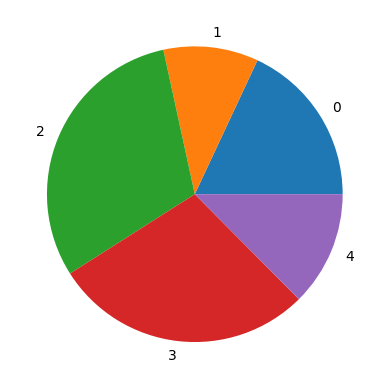

In [25]:
data.groupby("emoji").size().plot(kind="pie")

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   txt     183 non-null    object
 1   emoji   183 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [11]:
txt_len = len(max(data["txt"],key = len).split())
txt_len

10

## I.02 tokenizeation : 

In [12]:
tokenized = [word_tokenize(sent.lower()) for sent in data["txt"]]

In [13]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(data["txt"])

word_matrix = word_tokenizer.texts_to_sequences(data["txt"])

In [14]:
word_matrix_pad = pad_sequences(word_matrix,padding='post')

In [15]:
word_matrix_pad[:3]

array([[103, 104,   3,   6, 105,   0,   0,   0,   0,   0],
       [106,   3, 107,   0,   0,   0,   0,   0,   0,   0],
       [  1,   7, 108,   0,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [17]:
index2word = word_tokenizer.index_word
word2index = {}
for index,word in index2word.items():
    word2index[word] = index

In [20]:
cnt=0
for index , word in index2word.items():
    print(f"{index} : {word}")
    if cnt == 3:
        break
    cnt += 1
print("-"*10)
cnt=0  
for word , index in word2index.items():
    print(f"{word} : {index}")
    if cnt == 3:
        break
    cnt += 1

1 : i
2 : you
3 : is
4 : the
----------
i : 1
you : 2
is : 3
the : 4


In [29]:
vocab_num = len(word2index) + 1
vocab_num

313

# II. Word Embiding

In [21]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip

--2024-07-28 22:02:29--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
Resolving huggingface.co (huggingface.co)... 18.239.50.16, 18.239.50.49, 18.239.50.80, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.16|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27glove.6B.zip%3B+filename%3D%22glove.6B.zip%22%3B&response-content-type=application%2Fzip&Expires=1722463349&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMjQ2MzM0OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9zdGFuZm9yZG5scC9nbG92ZS82NDcxMzgyY2RkODM3NTQ0YmYzYWM3MjQ5N2EzODcxNWU4NDU4OTdkMjY1YjJiNDI0YjQ3NjE4MzIwMDljODM3P3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=h%7EAZs5XCoQ7ZiueYvycC5zYGmRV0ULS

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       

In [ ]:
!ls -lh

In [26]:
def load_glove_vectors(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()          
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Specify the path to the GloVe file
glove_file = "glove.6B.300d.txt"

# Load the GloVe vectors
glove = load_glove_vectors(glove_file)

In [34]:
glove["<unk>"].shape

(300,)

In [48]:
# 300 for glove vectors
embiding_matrix = np.zeros((vocab_num,300))
embiding_matrix[0] = glove["<unk>"]
embiding_matrix.shape

(313, 300)

In [50]:
for index , word in index2word.items() :
    embiding_matrix[index] = glove[word]

embiding_matrix

array([[ 0.42919099, -0.29689699,  0.15011001, ...,  0.28975001,
         0.32618001, -0.0590532 ],
       [-0.13292   ,  0.16985001, -0.1436    , ..., -0.23778   ,
         0.14766   ,  0.62901998],
       [-0.28426999,  0.047977  , -0.15062   , ..., -0.090071  ,
         0.016922  ,  0.29278001],
       ...,
       [-0.52109998,  0.65122998, -0.30188   , ..., -0.23667   ,
        -0.36634001,  0.16132   ],
       [-0.14154001,  0.027303  ,  0.13594   , ..., -0.40974   ,
         0.12668   ,  0.11425   ],
       [-0.41354999,  0.076012  ,  0.099178  , ...,  0.15953   ,
        -0.13223   ,  0.03091   ]])

## II.03 Split data : 

In [ ]:
np.array(data["emoji"]).reshape(183,1 )

In [92]:
OHE = OneHotEncoder()
y = OHE.fit_transform(np.array(data["emoji"]).reshape(183,1)).toarray()
y.shape

(183, 5)

In [95]:
y[:2]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [99]:
X_train , X_test ,y_train , y_test = train_test_split(word_matrix_pad,y,test_size=.2)

In [101]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((146, 10), (37, 10), (146, 5), (37, 5))

# II. Model : 

In [130]:
model = Sequential([
    Embedding(vocab_num, 300, weights=[embiding_matrix], input_length=txt_len, trainable=False),
    LSTM(units=128, return_sequences=True),
    Dropout(0.5),
    LSTM(units=128, return_sequences=False),
    Dropout(0.5),
    Dense(5),
    Activation('softmax')
])

In [131]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │        93,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,900 (366.80 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 93,900 (366.80 KB)

In [132]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [133]:
# early_stopping_acc = EarlyStopping(monitor='val_accuracy',min_delta=0.0001, patience=1, restore_best_weights=True)
# early_stopping_loss = EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=1, restore_best_weights=True)

history = model.fit(X_train,y_train,epochs=9, validation_data=(X_test, y_test)) #, callbacks=[early_stopping_acc,early_stopping_loss]

Epoch 1/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.2766 - loss: 1.5846 - val_accuracy: 0.3784 - val_loss: 1.5291
Epoch 2/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3777 - loss: 1.4498 - val_accuracy: 0.3514 - val_loss: 1.5386
Epoch 3/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4173 - loss: 1.3451 - val_accuracy: 0.4054 - val_loss: 1.4654
Epoch 4/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5490 - loss: 1.2119 - val_accuracy: 0.4595 - val_loss: 1.3169
Epoch 5/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6327 - loss: 1.0029 - val_accuracy: 0.4595 - val_loss: 1.1135
Epoch 6/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8091 - loss: 0.6796 - val_accuracy: 0.7297 - val_loss: 0.8143
Epoch 7/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8530 - loss: 0.5610 - val_accuracy: 0.5676 - val_loss: 0.9891
Epoch 8/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8426 - loss: 0.4663 - val_accuracy: 0.6757 - val_loss: 0.9191
Epoch 9

In [135]:
history_2 = model.fit(X_train,y_train,epochs=1, validation_data=(X_test, y_test))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8838 - loss: 0.2998 - val_accuracy: 0.7027 - val_loss: 0.6724


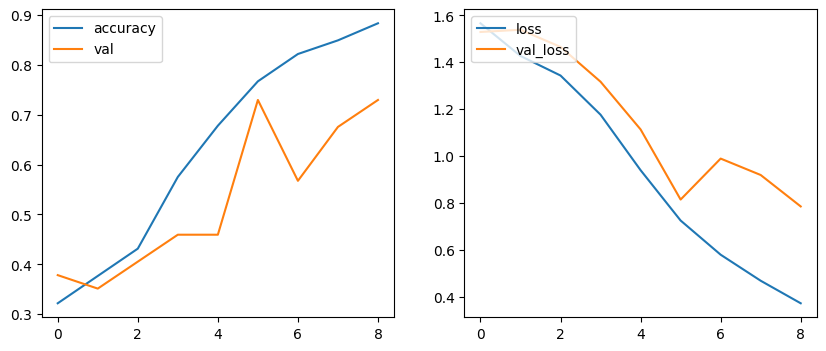

In [134]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'val_loss'], loc='upper left')

plt.show()

# III. Predect 

In [305]:
def pred(txt):
    tokenized = word_tokenize(str(txt).lower())
    word_vec = word_tokenizer.texts_to_sequences(tokenized)
    for i in range(len(word_vec)):
        if not word_vec[i]:
            word_vec[i] = [0]
    word_vec_pad = pad_sequences([word_vec],padding='post')
    p = model.predict(word_vec_pad)   
    print(f"{txt}",' '*(40-len(txt)),"|",emoji.emojize(emoji_dictionary[f"{list(p[0]).index(p[0].max())}"],language='alias'))

In [306]:
sents = ["I Love you...",
    "I am proud of your achievements",
    "I am so sad", 
    "French macaroon is so tasty",
]

for s in sents:
      pred(s)  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
I Love you...                             | 💖
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
I am proud of your achievements           | 😄
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
I am so sad                               | 😞
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
French macaroon is so tasty               | 🍴


# IV. Summary: 
#### *It was a generally successful experience, despite facing overfitting issues due to the very small data size.*